In [1]:
from __future__ import annotations
from typing import Optional, Tuple
import pandas as pd 
from copy import deepcopy
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import seaborn as sns
import numpy as np
from collections import defaultdict

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEER_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

Formatting

In [3]:
# basic formatting
from util_funcs import do_basic_formatting
HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
df = do_basic_formatting(master, HISTTYPES_PATH)

Missing 0 codes.


In [12]:
df['behavior'].value_counts()
# 73973 records
# 71510 patients

behavior
MALIGNANT     4614088
BENIGN         620539
BORDERLINE      15310
Name: count, dtype: int64

Filtering for incidence

In [9]:
from util_funcs import filter_for_incidence
filt_df = filter_for_incidence(df)



--- FILTERING: KEEP PATIENTS WITH 2+ RECORDS ---

Removed: 4310645 patients, 4310645 records
Remaining [Yes Brain Met]: 6474 patients
Remaining [Non Brain Met]: 432425 patients

Table peek (no bm):
   patient_id           cancer_type  diagnosis_year  patient_death_year  brain_met
0         340                Breast            2012                 NaN      False
1         340                Breast            2013                 NaN      False
2        1009              Prostate            2013            2,021.00      False
3        1009                Ureter            2019            2,021.00      False
4        1030  Melanoma of the Skin            2015                 NaN      False

Table peek (yes bm):
     patient_id           cancer_type  diagnosis_year  patient_death_year  brain_met
232       24007       Urinary Bladder            2010            2,012.00      False
233       24007  Melanoma of the Skin            2010            2,012.00      False
234       24007     Lung 

In [24]:
# filt_df[filt_df['patient_id']==340]
# filt_df['behavior'].value_counts()
# filt_df.groupby('patient_id')['cancer_type'].unique()
view = filt_df[filt_df['brain_met']==True]['patient_id'].value_counts().sort_values(ascending=False)
view[view >= 2]

patient_id
11203054    3
33670569    3
16495938    2
20287358    2
5602847     2
54791158    2
1322461     2
16546818    2
62533859    2
22243098    2
46786824    2
35428799    2
32197103    2
35724432    2
11037217    2
22319491    2
50088477    2
11025458    2
11046129    2
5835031     2
62546325    2
Name: count, dtype: int64

In [26]:
filt_df[filt_df['patient_id']==16495938]

,patient_id,patient_death_year,diagnosis_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr
151346,16495938,"2,013.00",2012,80-84 years,Melanoma of the Skin,Skin,Melanoma of the Skin,Skin,T2a,N0,IB,NaN,NaN,NaN,NaN,NaN,NaN,MALIGNANT,3,0,NaN,NaN,8721,nevi and melanomas,False,False,False,False,NaN,Nodular melanoma
151347,16495938,"2,013.00",2013,80-84 years,Lung and Bronchus,Lung and Bronchus,Lung and Bronchus,Lung and Bronchus,T2,N2,IV,NaN,NaN,NaN,NaN,NaN,NaN,MALIGNANT,3,0,NaN,NaN,8010,"epithelial neoplasms, NOS",True,False,True,False,NaN,Carcinoma [+ others]
151348,16495938,"2,013.00",2013,80-84 years,Lung and Bronchus,Lung and Bronchus,Lung and Bronchus,Lung and Bronchus,T2,N2,IV,NaN,NaN,NaN,NaN,NaN,NaN,MALIGNANT,3,0,NaN,NaN,8070,squamous cell neoplasms,True,False,True,False,NaN,Actinic kertosis [+ others]


Formatting for incidence

In [8]:
from util_funcs import format_for_incidence
fmt_df = format_for_incidence(filt_df)


NameError: name 'filt_df' is not defined

In [ ]:
DISPLAY_FIELDS = ['patient_id', 'cancer_type', 'diagnosis_year', 'patient_death_year', 'brain_met', 'timepoint2', 'observed']
print(fmt_df[fmt_df['observed']==False][DISPLAY_FIELDS].head(15))
print()
print(fmt_df[fmt_df['observed']==True][DISPLAY_FIELDS].head(15))

# what to do about patient like this???
#     patient_id                       cancer_type  diagnosis_year  patient_death_year  brain_met  timepoint2  observed
# 9         1040                            Breast            2014                 NaN      False      2020.0     False
# 9         1040           Kidney and Renal Pelvis            2016                 NaN      False      2020.0     False

In [ ]:
from util_funcs import finalise_incidence_df
incidence_df = finalise_incidence_df(fmt_df)

In [ ]:
DISPLAY_FIELDS = ['patient_id', 'cancer_type', 'diagnosis_year', 'patient_death_year', 'timepoint2', 'observed']
print(incidence_df[incidence_df['observed']==False][DISPLAY_FIELDS].head(10))
print()
print(incidence_df[incidence_df['observed']==True][DISPLAY_FIELDS].head(10))

In [158]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

def plot_survival(df: pd.DataFrame, label: str) -> None:
    # mysubset = merged.loc[merged['cancer_type']=='Melanoma of the Skin']
    # mysubset = merged.loc[merged['cancer_type']=='Lung and Bronchus']
    time, survival_prob, conf_int = kaplan_meier_estimator(
        df["observed"], df["timerange"], conf_type="log-log"
    )
    plt.step(time, survival_prob, where="post", label=label)
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    plt.ylim(0.92, 1)
    plt.xlim(0.9, 11)
    plt.ylabel(r"est. probability of no brain metastasis")
    plt.xlabel("time $t$")
    plt.legend()
    plt.title('Testing')


In [160]:
# Incidence = (New Cases) / (Population x Timeframe)

# the issue here is it's biased against patients with denovo brain met at first contact. 
# this data just says "for patients which DIDNT have bm at first contact, how many went on to develop bm"

# TODO for survival plots, add patients back-in which present with brain met at initial contact. 

DISPLAY_FIELDS = ['patient_id', 'cancer_type', 'diagnosis_year', 'patient_death_year', 'timepoint2', 'observed']

def calc_incidence_rates(feature: str, df: pd.DataFrame) -> pd.DataFrame:
    INCIDENCE_LABEL = 'incidence_rate (cases per 1000 ppl per year)'
    RISK_LABEL = 'risk (chance of developing bm before death)'
    MIN_AT_RISK = 1000
    the_dict = defaultdict(dict)
    fvals = list(df[feature].unique())
    for fval in fvals:
        # only keep the earliest record per patient per feature value
        dfslice = df[df[feature]==fval][['patient_id', 'diagnosis_year', 'timerange', 'timepoint2', 'observed']]
        dfslice.sort_values(by=['patient_id', 'diagnosis_year'], ascending=[True, True], ignore_index=True)
        dfslice = dfslice.drop_duplicates(subset=['patient_id'], keep='first', ignore_index=True)

        if dfslice.shape[0] > MIN_AT_RISK:
            the_dict[fval]['at_risk'] = dfslice.shape[0]
            the_dict[fval]['developed_bm'] = dfslice['observed'].sum()
            the_dict[fval]['people_years'] = dfslice['timerange'].sum()
            the_dict[fval][INCIDENCE_LABEL] = (the_dict[fval]['developed_bm'] / the_dict[fval]['people_years']) * 1000
            the_dict[fval][RISK_LABEL] = (the_dict[fval]['developed_bm'] / the_dict[fval]['at_risk']) * 100

    idf = pd.DataFrame.from_dict(data=the_dict, orient='index')
    idf['people_years'] = idf['people_years'].apply(int)
    idf['developed_bm'] = idf['developed_bm'].apply(int)
    idf = idf.sort_values(by=INCIDENCE_LABEL, ascending=False)
    # idf = idf.sort_values(by=RISK_LABEL, ascending=False)
    print(idf.head(20))
    return idf



                                  at_risk  developed_bm  people_years  incidence_rate (cases per 1000 ppl per year)  risk (chance of developing bm before death)
Larynx                               4309            84         17257                                          4.87                                         1.95
Urinary Bladder                     24433           326         90353                                          3.61                                         1.33
Prostate                            40732           630        177794                                          3.54                                         1.55
Cervix                               1798            23          6790                                          3.39                                         1.28
Throat                               1701            19          5921                                          3.21                                         1.12
Ureter                            

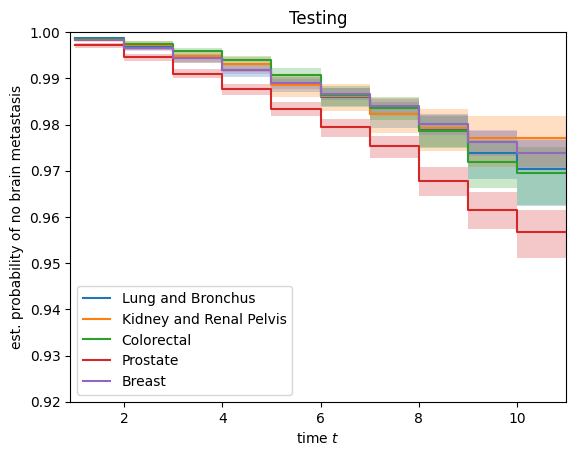

In [161]:
incidence_df['timerange'] = incidence_df['timepoint2'] - incidence_df['diagnosis_year']
calc_incidence_rates('cancer_group', incidence_df)
plot_survival(incidence_df.loc[incidence_df['cancer_group']=='Lung and Bronchus'], 'Lung and Bronchus')
plot_survival(incidence_df.loc[incidence_df['cancer_group']=='Kidney and Renal Pelvis'], 'Kidney and Renal Pelvis')
plot_survival(incidence_df.loc[incidence_df['cancer_group']=='Colorectal'], 'Colorectal')
plot_survival(incidence_df.loc[incidence_df['cancer_group']=='Prostate'], 'Prostate')
plot_survival(incidence_df.loc[incidence_df['cancer_group']=='Breast'], 'Breast')

# idf = calc_incidence_rates('hist_type_descr', incidence_df)
# idf = calc_incidence_rates('hist_cateogry', incidence_df)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

-------------------------------

patient has 2+ years on record

In [ ]:
# print('\nstarting shape:')
# print(df.shape)
# pids = df.groupby('patient_id', as_index=False)['diagnosis_year'].nunique()
# print('\nnum unique diagnosis_years per patient')
# print(pids.shape)
# print(pids.head())
# pids = pids[pids['diagnosis_year'] >= 2]
# keep_pids = pids['patient_id'].unique()
# df = df[df['patient_id'].isin(keep_pids)]
# print('\nfinal shape:')
# print(df.shape)
# df.reset_index(drop=True, inplace=True)


patient did not have brain met at first timepoint

In [ ]:
# # sort by brain_met->year->pid so that first record will be earliest. 
# # if multiple records at first timepoint, if 1+ are marked brain met positive, these records will be the first.
# num_brainmet_patients = len(df[df['brain_met']==True]['patient_id'].unique())
# num_brainmet_records = df[df['brain_met']==True].shape[0]
# num_nonbrainmet_patients = len(df[df['brain_met']==False]['patient_id'].unique())
# num_nonbrainmet_records = df[df['brain_met']==False].shape[0]
# print('\nStart --- ')
# print(f'Brain met: {num_brainmet_patients} patients, {num_brainmet_records} records')
# print(f'No Brain met: {num_nonbrainmet_patients} patients, {num_nonbrainmet_records} records')

# initial_pids = len(df['patient_id'].unique())
# initial_records = df.shape[0]
# df.sort_values(by=['patient_id', 'diagnosis_year', 'brain_met'], ascending=[True, True, False], ignore_index=True)
# print('\nsorted table:')
# print(df[['patient_id', 'patient_death_year', 'diagnosis_year', 'brain_met']].head(15))

# # select first record for each patient
# first_records = df.drop_duplicates(subset=['patient_id'], keep='first', ignore_index=True)

# # identify pids to keep (first record can't include brain met)
# keep_pids = set(first_records[first_records['brain_met'] == False]['patient_id'].unique())
# reject_pids = set(first_records[first_records['brain_met'] == True]['patient_id'].unique())

# # do subsetting
# df = df[df['patient_id'].isin(keep_pids)]

# # reporting
# final_pids = len(df['patient_id'].unique())
# final_records = df.shape[0]

# num_brainmet_patients = len(df[df['brain_met']==True]['patient_id'].unique())
# num_brainmet_records = df[df['brain_met']==True].shape[0]
# num_nonbrainmet_patients = len(df[df['brain_met']==False]['patient_id'].unique())
# num_nonbrainmet_records = df[df['brain_met']==False].shape[0]
# print('\nEnd --- ')
# print(f'\nRemoved {initial_pids - final_pids} patients ({initial_records - final_records} records) who had brain met at initial contact')
# print(f'Brain met: {num_brainmet_patients} patients, {num_brainmet_records} records')
# print(f'No Brain met: {num_nonbrainmet_patients} patients, {num_nonbrainmet_records} records')

# # print(df[['patient_id', 'patient_death_year', 'diagnosis_year', 'brain_met']].head(15))
# # df[df['brain_met']==True][['patient_id', 'patient_death_year', 'diagnosis_year', 'brain_met']].head(15)
# # # somewhat interesting - patients with multiple tumors, which had brain met at initial timepoint
# # print(df[df['patient_id'].isin(reject_pids)][['patient_id', 'patient_death_year', 'diagnosis_year', 'brain_met']].head(20))



second timepoint:
- [observed] year patient developed brain met, or 
- [censored] year of death, or 
- [censored] last record date (still alive)

In [ ]:
### build dataframe of patient info ###
pinfo = pd.DataFrame(index=df['patient_id'])
# print(pinfo.shape)
# print(pinfo.head())

# death year
pinfo['death_year'] = df.groupby('patient_id')['patient_death_year'].first()
# print(pinfo.shape)
# print(pinfo.head())

# brain met year (if applicable)
pinfo['brainmet_year'] = df[df['brain_met']==True].groupby('patient_id')['diagnosis_year'].agg('min')
# print(pinfo.shape)
# print(pinfo.head())

# last contact
pinfo['last_contact'] = df.groupby('patient_id')['diagnosis_year'].agg('max')
# print(pinfo.shape)
# print(pinfo.head(15))

### assigning timepoint 2 (multistage approach, reassigning for NaNs) ###
# [observed] brain met 
pinfo['observed'] = True
pinfo['timepoint2'] = pinfo['brainmet_year']
pinfo.reset_index(inplace=True)
print('\nfirst assign')
print(pinfo.shape)
print(pinfo.head(10))

# [censored] patient death year 
pinfo.loc[pinfo['timepoint2'].isna(), 'observed'] = False
pinfo.loc[pinfo['timepoint2'].isna(), 'timepoint2'] = pinfo['death_year']
print('\nsecond assign')
print(pinfo.shape)
print(pinfo.head(10))

# [censored] patient last contact
pinfo.loc[pinfo['timepoint2'].isna(), 'timepoint2'] = pinfo['last_contact']
print('\nthird assign')
print(pinfo.shape)
print(pinfo.head(10))

pinfo = pinfo.drop_duplicates(subset=['patient_id'], keep='first', ignore_index=True)
print(pinfo['observed'].value_counts())
print(pinfo.head(10))

pinfo[pinfo['brainmet_year'].notna()].head()

# print(df.shape)
# print(df[['patient_id', 'patient_death_year', 'diagnosis_year', 'brain_met']].head(15))


In [ ]:
df.loc[df['patient_id']==69340][['patient_id', 'cancer_type', 'diagnosis_year', 'patient_death_year', 'brain_met']]

merge dataframes

In [ ]:


assert set(pinfo['patient_id'].unique()) == set(df['patient_id'].unique())
temp = pinfo[['patient_id', 'timepoint2', 'observed']]
merged = df.merge(temp, on='patient_id')
merged.reset_index(drop=True)
merged.rename(columns={'diagnosis_year': 'timepoint1'}, inplace=True)
merged['timepoint2'] = merged['timepoint2'].apply(int)
merged = merged[merged['timepoint1']!=merged['timepoint2']]
merged['timerange'] = merged['timepoint2'] - merged['timepoint1']
merged = merged[merged['timerange'] > 0] # needed because of patients such as pid=1206082 (see below)
print(merged.shape)
# merged[merged['observed']==True][['patient_id', 'cancer_type', 'patient_death_year', 'brain_met', 'timepoint1', 'timepoint2', 'timerange', 'observed']]
# merged.loc[merged['patient_id']==69340][['patient_id', 'cancer_type', 'patient_death_year', 'brain_met', 'timepoint1', 'timepoint2', 'observed']].head(10)
# print(df.shape)
# print(temp.shape)
# print(merged.shape)
# merged.rename(columns={'diagnosis_year': 'timepoint1'}, inplace=True)
# print(merged[['patient_id', 'cancer_type', 'patient_death_year', 'brain_met', 'timepoint1', 'timepoint2', 'observed']].head(10))
# print(df[['patient_id', 'cancer_type', 'patient_death_year', 'brain_met', 'diagnosis_year']].head(10))
# merged.loc[df['patient_id']==69340]
# merged[merged['brain_met']==True][['patient_id', 'cancer_type', 'patient_death_year', 'brain_met', 'timepoint1', 'timepoint2', 'observed']].head(10)


In [ ]:
df[df['patient_id']==1206082][['patient_id', 'cancer_type', 'diagnosis_year', 'patient_death_year', 'brain_met']]

In [ ]:
# print(merged[merged['observed']==False]['cancer_type'].value_counts())
# print(merged[merged['observed']==True]['cancer_type'].value_counts())

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

def plot_survival(df: pd.DataFrame, label: str) -> None:
    # mysubset = merged.loc[merged['cancer_type']=='Melanoma of the Skin']
    # mysubset = merged.loc[merged['cancer_type']=='Lung and Bronchus']
    time, survival_prob, conf_int = kaplan_meier_estimator(
        df["observed"], df["timerange"], conf_type="log-log"
    )
    plt.step(time, survival_prob, where="post", label=label)
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    plt.ylim(0.9, 1)
    plt.xlim(0.9, 11)
    plt.ylabel(r"est. probability of no brain metastasis")
    plt.xlabel("time $t$")
    plt.legend()
    plt.title('Testing')

plot_survival(merged.loc[merged['cancer_type']=='Prostate'], 'Prostate')
plot_survival(merged.loc[merged['cancer_type']=='Breast'], 'Breast')
plot_survival(merged.loc[merged['cancer_type']=='Melanoma of the Skin'], 'Melanoma of the Skin')
plot_survival(merged.loc[merged['cancer_type']=='Lung and Bronchus'], 'Lung and Bronchus')
